## Gathering Dependencies

_Importing Required Libraries_

In [1]:
pip install hampel

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Anurag Dutta\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [2]:
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import LSTM
import keras
import tensorflow as tf
from hampel import hampel
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from matplotlib import pyplot
from numpy import array
from tensorflow.keras.callbacks import EarlyStopping

## Loading Datasets

_SAN JUAN_

In [3]:
data = pd.read_csv("datasets/sanjuan.csv")
training_set = data.iloc[:, 3]
print(training_set)

0        4
1        5
2        4
3        3
4        6
        ..
1191    56
1192    46
1193    52
1194    34
1195    25
Name: Cases, Length: 1196, dtype: int64


## Preprocessing the Data

In [4]:
# Multivariate data preparation
from numpy import array

# split a Multivariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out, features):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# choose a number of time steps
n_steps_out = 52
n_steps_in = 10
n_features = 1

# split into samples
X, y = split_sequence(training_set, n_steps_in, n_steps_out, n_features)
# summarize the data
for i in range(len(X)):
	print(X[i], y[i])

[ 4  5  4  3  6  2  4  5 10  6] [ 8  2  6 17 23 13 21 28 24 20 40 27 42 33 43 37 57 71 44 56 53 52 47 26
 27 21 21 26 34 37 17 19 25 18 21 17 17 16 16 15 23 16 17 12 17 10 15 19
 21 14 18 13]
[ 5  4  3  6  2  4  5 10  6  8] [ 2  6 17 23 13 21 28 24 20 40 27 42 33 43 37 57 71 44 56 53 52 47 26 27
 21 21 26 34 37 17 19 25 18 21 17 17 16 16 15 23 16 17 12 17 10 15 19 21
 14 18 13 14]
[ 4  3  6  2  4  5 10  6  8  2] [ 6 17 23 13 21 28 24 20 40 27 42 33 43 37 57 71 44 56 53 52 47 26 27 21
 21 26 34 37 17 19 25 18 21 17 17 16 16 15 23 16 17 12 17 10 15 19 21 14
 18 13 14 18]
[ 3  6  2  4  5 10  6  8  2  6] [17 23 13 21 28 24 20 40 27 42 33 43 37 57 71 44 56 53 52 47 26 27 21 21
 26 34 37 17 19 25 18 21 17 17 16 16 15 23 16 17 12 17 10 15 19 21 14 18
 13 14 18 23]
[ 6  2  4  5 10  6  8  2  6 17] [23 13 21 28 24 20 40 27 42 33 43 37 57 71 44 56 53 52 47 26 27 21 21 26
 34 37 17 19 25 18 21 17 17 16 16 15 23 16 17 12 17 10 15 19 21 14 18 13
 14 18 23 25]
[ 2  4  5 10  6  8  2  6 17 23] [13 21 2

## Train and Test Split

In [5]:
train_size = int(len(y) * 0.8)
test_size = len(y) - train_size
dataX = np.array(X)
dataY = np.array(y)
trainX = np.array(X[0:train_size])
trainY = np.array(y[0:train_size])
testX = np.array(X[train_size:len(X)])
testY = np.array(y[train_size:len(y)])
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
testX = testX.reshape((testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(908, 1, 10) (908, 52) (227, 1, 10) (227, 52)


## Model (Without Monte Carlo Dropout)

In [6]:
# split a Multivariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out, features):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# choose a number of time steps
n_steps_out = 52
n_steps_in = 10
n_features = 1

# split into samples
X, y = split_sequence(training_set, n_steps_in, n_steps_out, n_features)

n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
test_days = 325
trainX, trainY = X[:-test_days], y[:-test_days]
testX, testY = X[-test_days:], y[-test_days:]

custom_early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=1, 
    min_delta=10, 
    mode='min'
)

model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(52))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(trainX, trainY, epochs=500, batch_size=64, validation_data=(testX, testY), shuffle=False, callbacks=[custom_early_stopping])

Epoch 1/500
13/13 [==============================] - 2s 48ms/step - loss: 4165.9619 - val_loss: 4484.5806
Epoch 2/500
13/13 [==============================] - 0s 9ms/step - loss: 4149.9258 - val_loss: 4461.7300
Epoch 3/500
13/13 [==============================] - 0s 10ms/step - loss: 4128.0610 - val_loss: 4426.4463
Epoch 4/500
13/13 [==============================] - 0s 9ms/step - loss: 4093.6597 - val_loss: 4370.7993
Epoch 5/500
13/13 [==============================] - 0s 8ms/step - loss: 4041.3098 - val_loss: 4296.5552
Epoch 6/500
13/13 [==============================] - 0s 7ms/step - loss: 3976.2917 - val_loss: 4215.9746
Epoch 7/500
13/13 [==============================] - 0s 9ms/step - loss: 3912.7266 - val_loss: 4144.2314
Epoch 8/500
13/13 [==============================] - 0s 10ms/step - loss: 3857.1062 - val_loss: 4082.8262
Epoch 9/500
13/13 [==============================] - 0s 8ms/step - loss: 3808.0459 - val_loss: 4028.4519
Epoch 10/500
13/13 [==============================] 

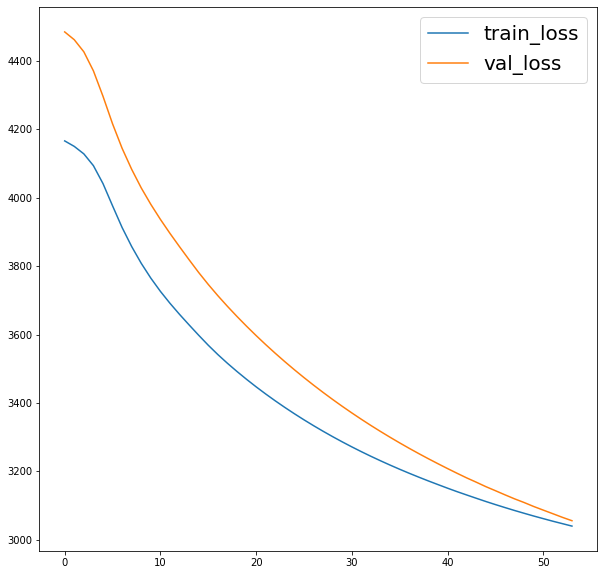

In [7]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10] # for square canvas
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(fontsize=20)
plt.show()

## Metrics (Without Monte Carlo Dropout)

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
textX_without_mc = testX
textY_without_mc = testY
yhat_without_mc = model.predict(textX_without_mc)
print(yhat_without_mc.shape)
textX_without_mc = textX_without_mc.reshape((textX_without_mc.shape[0], textX_without_mc.shape[2]*10))
print(textX_without_mc.shape)
inv_yhat_without_mc = np.concatenate((textX_without_mc, yhat_without_mc), axis=1)
inv_yhat1_without_mc = inv_yhat_without_mc[:, -3:]
inv_yhat_without_mc = inv_yhat_without_mc[:, -3]
inv_y_without_mc = np.concatenate((textX_without_mc, textY_without_mc), axis=1)
inv_y1_without_mc = inv_y_without_mc[:, -3:]
inv_y_without_mc = inv_y_without_mc[:, -3]
rmse_without_mc = np.sqrt(mean_squared_error(inv_y_without_mc, inv_yhat_without_mc))
mae_without_mc = mean_absolute_error(inv_y_without_mc, inv_yhat_without_mc)
print('Test RMSE: %.3f' % rmse_without_mc)
print('Test MAE: %.3f' % mae_without_mc)

11/11 [==============================] - 1s 2ms/step
(325, 52)
(325, 10)
Test RMSE: 64.595
Test MAE: 37.650


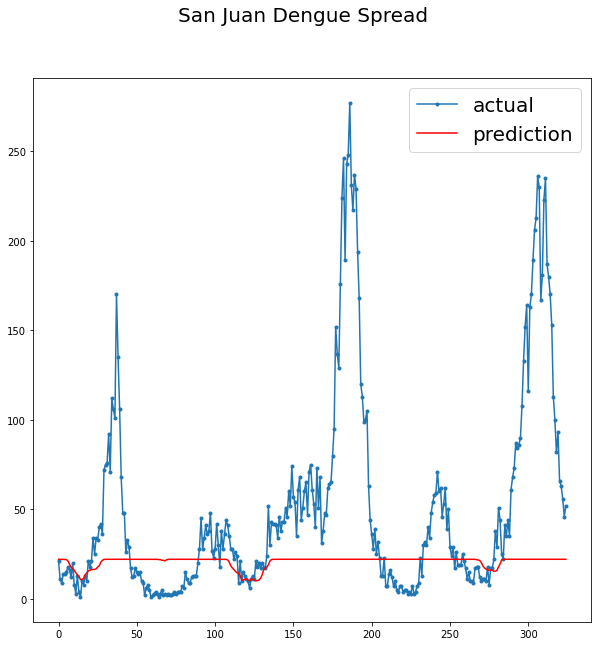

In [9]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10] # for square canvas
plt.plot(inv_y_without_mc, marker='.', label="actual")
plt.plot(inv_yhat_without_mc, 'r', label="prediction")
plt.suptitle('San Juan Dengue Spread', fontsize=20)
plt.legend(fontsize=20)
plt.show()

## Model (With Monte Carlo Dropout)

In [10]:
class MCDropout(Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [11]:
# split a Multivariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out, features):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# choose a number of time steps
n_steps_out = 52
n_steps_in = 10
n_features = 1

# split into samples
X, y = split_sequence(training_set, n_steps_in, n_steps_out, n_features)

n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
test_days = 325
trainX, trainY = X[:-test_days], y[:-test_days]
testX, testY = X[-test_days:], y[-test_days:]

custom_early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=1, 
    min_delta=10, 
    mode='min'
)

model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(52))
model.add(MCDropout(0.4))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(trainX, trainY, epochs=500, batch_size=64, validation_data=(testX, testY), shuffle=False, callbacks=[custom_early_stopping])

Epoch 1/500
13/13 [==============================] - 3s 42ms/step - loss: 4169.6709 - val_loss: 4485.9683
Epoch 2/500
13/13 [==============================] - 0s 10ms/step - loss: 4151.0806 - val_loss: 4462.4673
Epoch 3/500
13/13 [==============================] - 0s 8ms/step - loss: 4130.4150 - val_loss: 4431.6035
Epoch 4/500
13/13 [==============================] - 0s 8ms/step - loss: 4098.3760 - val_loss: 4382.7036
Epoch 5/500
13/13 [==============================] - 0s 10ms/step - loss: 4055.8081 - val_loss: 4322.1045
Epoch 6/500
13/13 [==============================] - 0s 8ms/step - loss: 4004.0950 - val_loss: 4251.6558
Epoch 7/500
13/13 [==============================] - 0s 8ms/step - loss: 3946.6462 - val_loss: 4188.9048
Epoch 8/500
13/13 [==============================] - 0s 7ms/step - loss: 3898.6331 - val_loss: 4134.4258
Epoch 9/500
13/13 [==============================] - 0s 7ms/step - loss: 3862.8958 - val_loss: 4084.3870
Epoch 10/500
13/13 [==============================] 

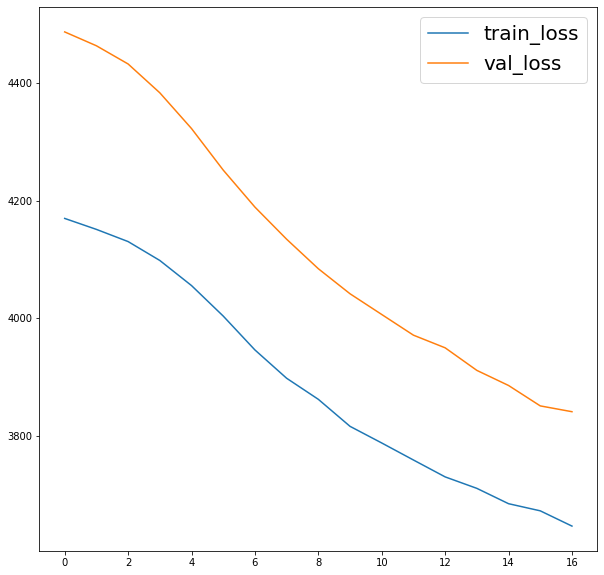

In [12]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10] # for square canvas
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(fontsize=20)
plt.show()

## Metrics (With Monte Carlo Dropout)

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
textX_with_mc = testX
textY_with_mc = testY
yhat_with_mc = model.predict(textX_with_mc)
print(yhat_with_mc.shape)
textX_with_mc = testX.reshape((textX_with_mc.shape[0], textX_with_mc.shape[2]*10))
print(textX_with_mc.shape)
inv_yhat_with_mc = np.concatenate((textX_with_mc, yhat_with_mc), axis=1)
inv_yhat1_with_mc = inv_yhat_with_mc[:, -3:]
inv_yhat_with_mc = inv_yhat_with_mc[:, -3]
inv_y_with_mc = np.concatenate((textX_with_mc, textY_with_mc), axis=1)
inv_y1_with_mc = inv_y_with_mc[:, -3:]
inv_y_with_mc = inv_y_with_mc[:, -3]
rmse_with_mc = np.sqrt(mean_squared_error(inv_y_with_mc, inv_yhat_with_mc))
mae_with_mc = mean_absolute_error(inv_y_with_mc, inv_yhat_with_mc)
print('Test RMSE: %.3f' % rmse_with_mc)
print('Test MAE: %.3f' % mae_with_mc)

11/11 [==============================] - 0s 2ms/step
(325, 52)
(325, 10)
Test RMSE: 72.839
Test MAE: 44.402


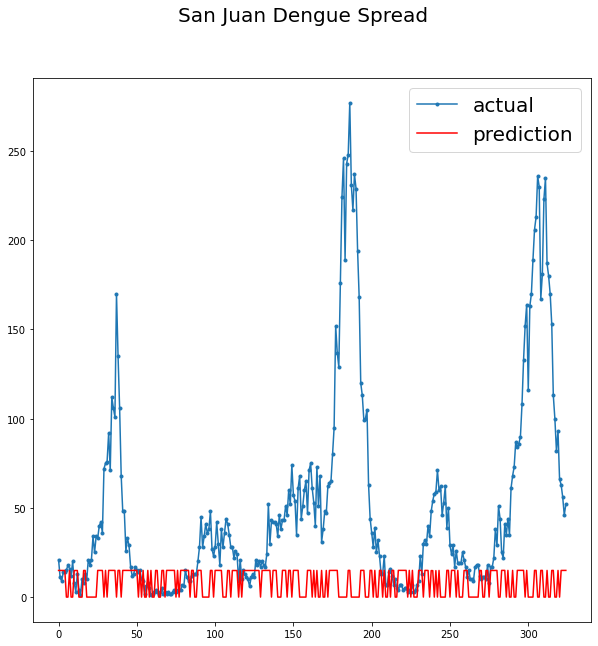

In [14]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10] # for square canvas
plt.plot(inv_y_with_mc, marker='.', label="actual")
plt.plot(inv_yhat_with_mc, 'r', label="prediction")
plt.suptitle('San Juan Dengue Spread', fontsize=20)
plt.legend(fontsize=20)
plt.show()